## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm

## Load Data

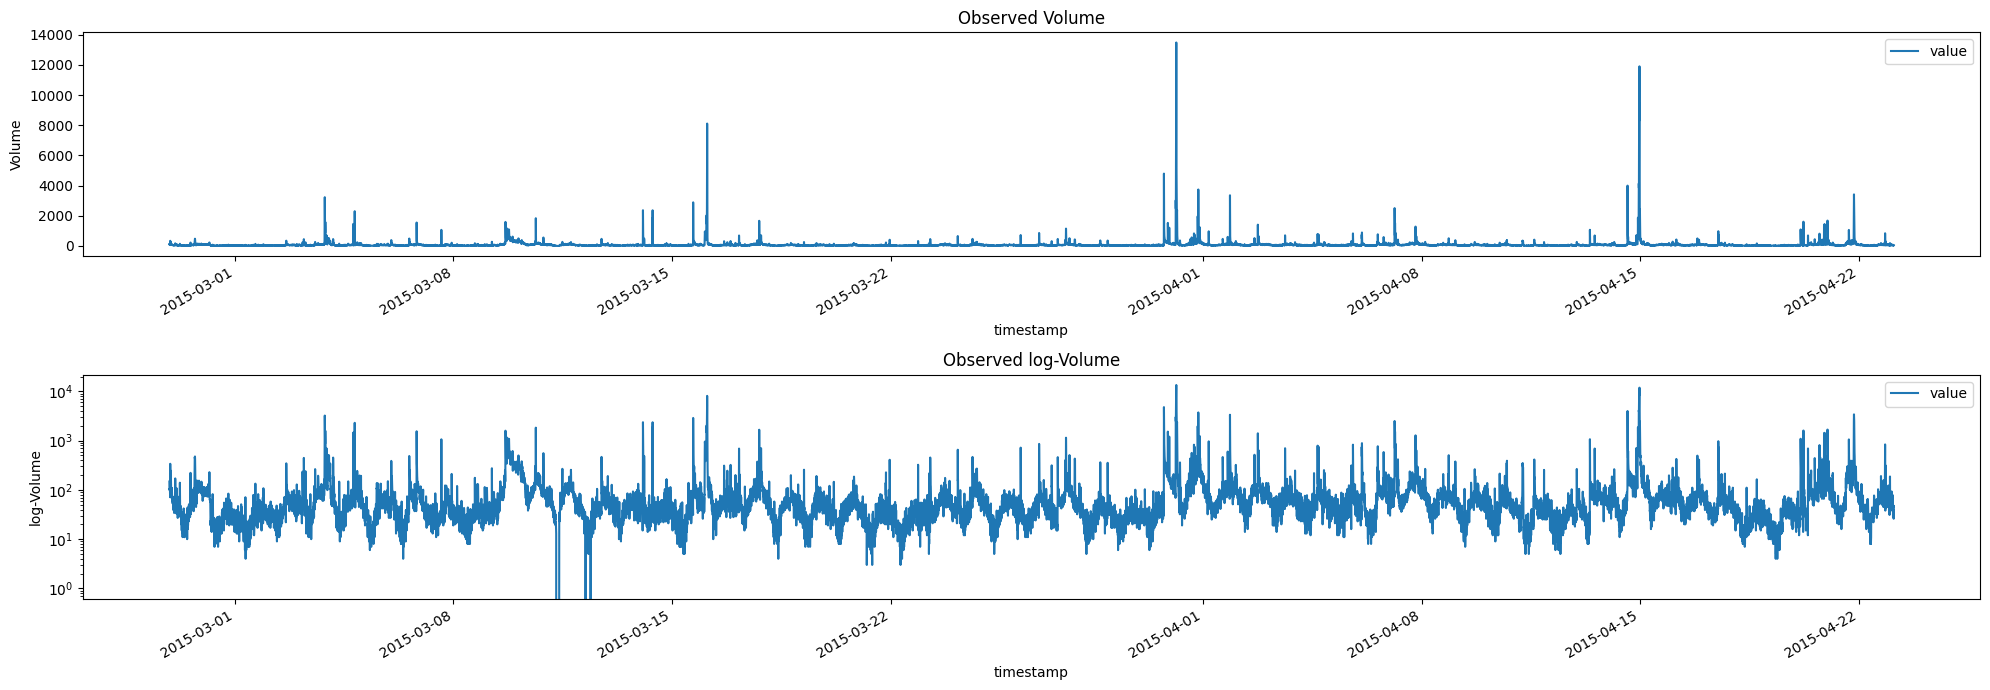

In [21]:
data_file = "data/Twitter_volume_AAPL.csv"
df = pd.read_csv(data_file)
df.index = pd.to_datetime(df.timestamp)

fig, ax = plt.subplots(2,1,figsize=(20,7))
df.plot(ax = ax[0])
ax[0].set_title('Observed Volume')
ax[0].set_ylabel('Volume')

ax[1].set_yscale('log')
df.plot(ax = ax[1])
ax[1].set_title('Observed log-Volume')
ax[1].set_ylabel('log-Volume')

plt.tight_layout()
plt.show()

# A posteriori analysis

In [3]:
cycle_freq = int(24 * (60 / 5))

df['ma'] = df['value'].rolling(window= cycle_freq, center=True, min_periods=1).mean()
df['pct_diff'] = df['value'] / df['ma']
trend = np.array([df['pct_diff'][i::cycle_freq].mean() for i in range(cycle_freq)])

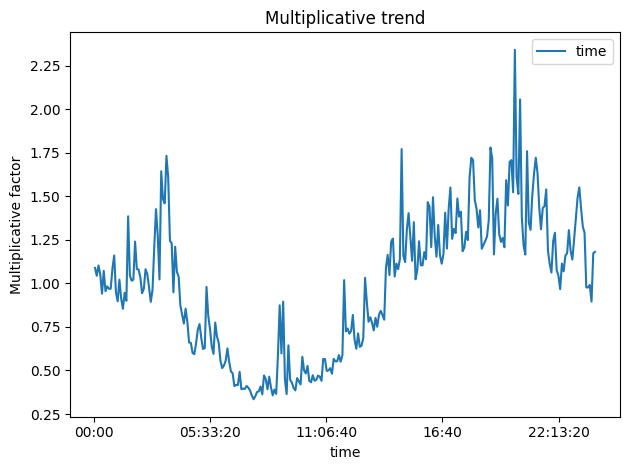

In [4]:
df_trend = pd.DataFrame(trend, index=pd.to_datetime(df.timestamp).dt.time.unique()).sort_index()
df_trend.columns = ['time']
df_trend.plot()
plt.title('Multiplicative trend')
plt.ylabel('Multiplicative factor')
plt.tight_layout()
plt.show()

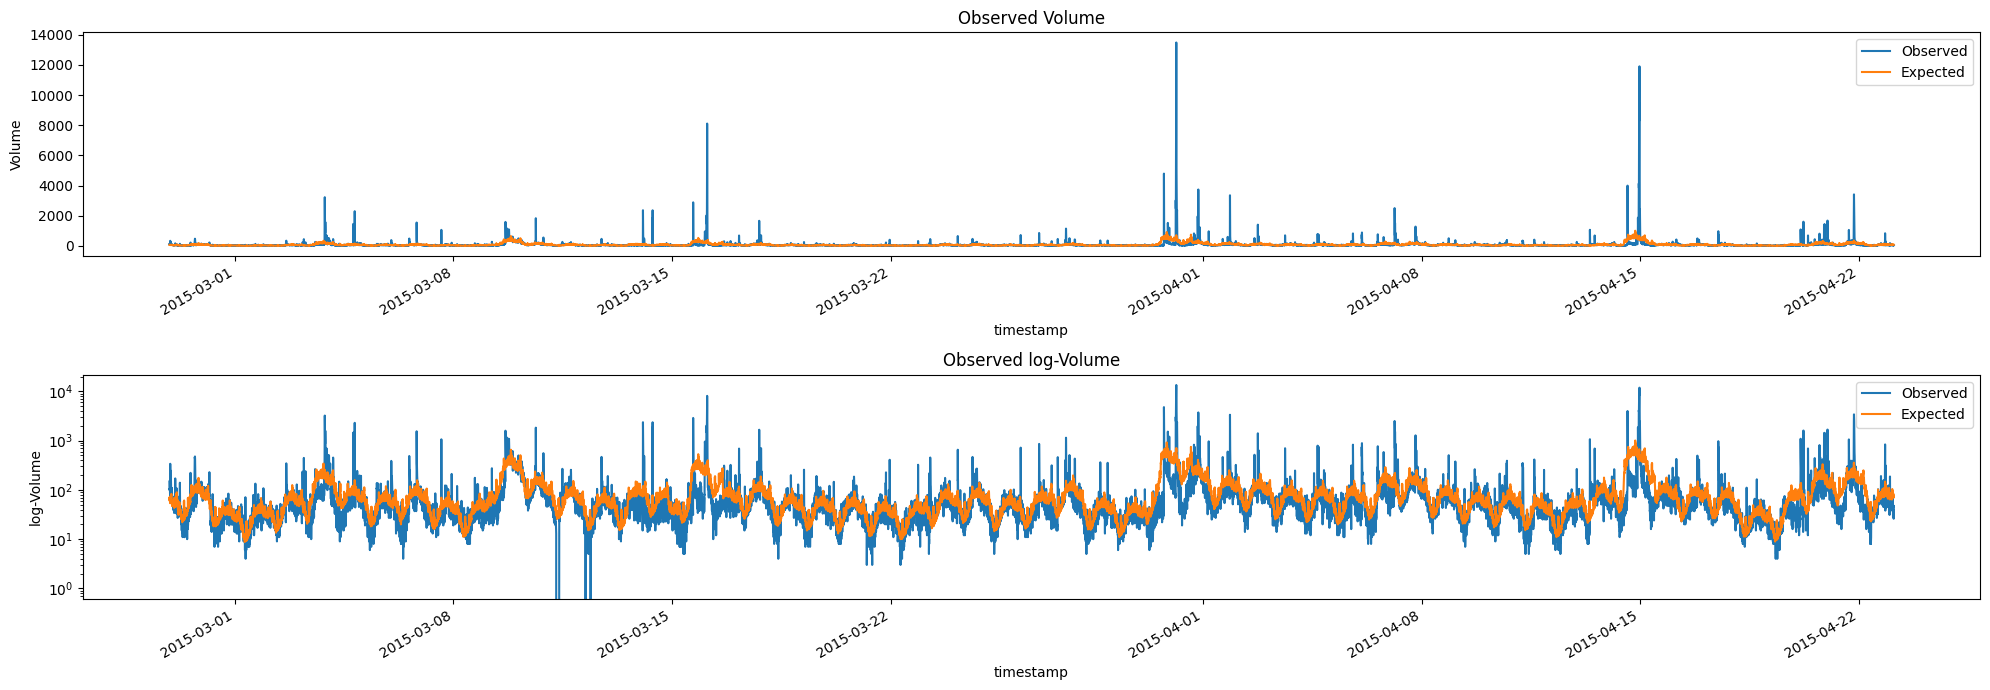

In [5]:
df['expected_val'] = df['ma'] * trend[np.arange(len(df)) % cycle_freq]

fig, ax = plt.subplots(2,1,figsize=(20,7))

df.value.plot(ax = ax[0], label='Observed')
df.expected_val.plot(ax = ax[0], label ='Expected')
ax[0].set_title('Observed Volume')
ax[0].set_ylabel('Volume')

ax[1].set_yscale('log')
df.value.plot(ax = ax[1], label='Observed')
df.expected_val.plot(ax = ax[1], label ='Expected')
ax[1].set_title('Observed log-Volume')
ax[1].set_ylabel('log-Volume')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

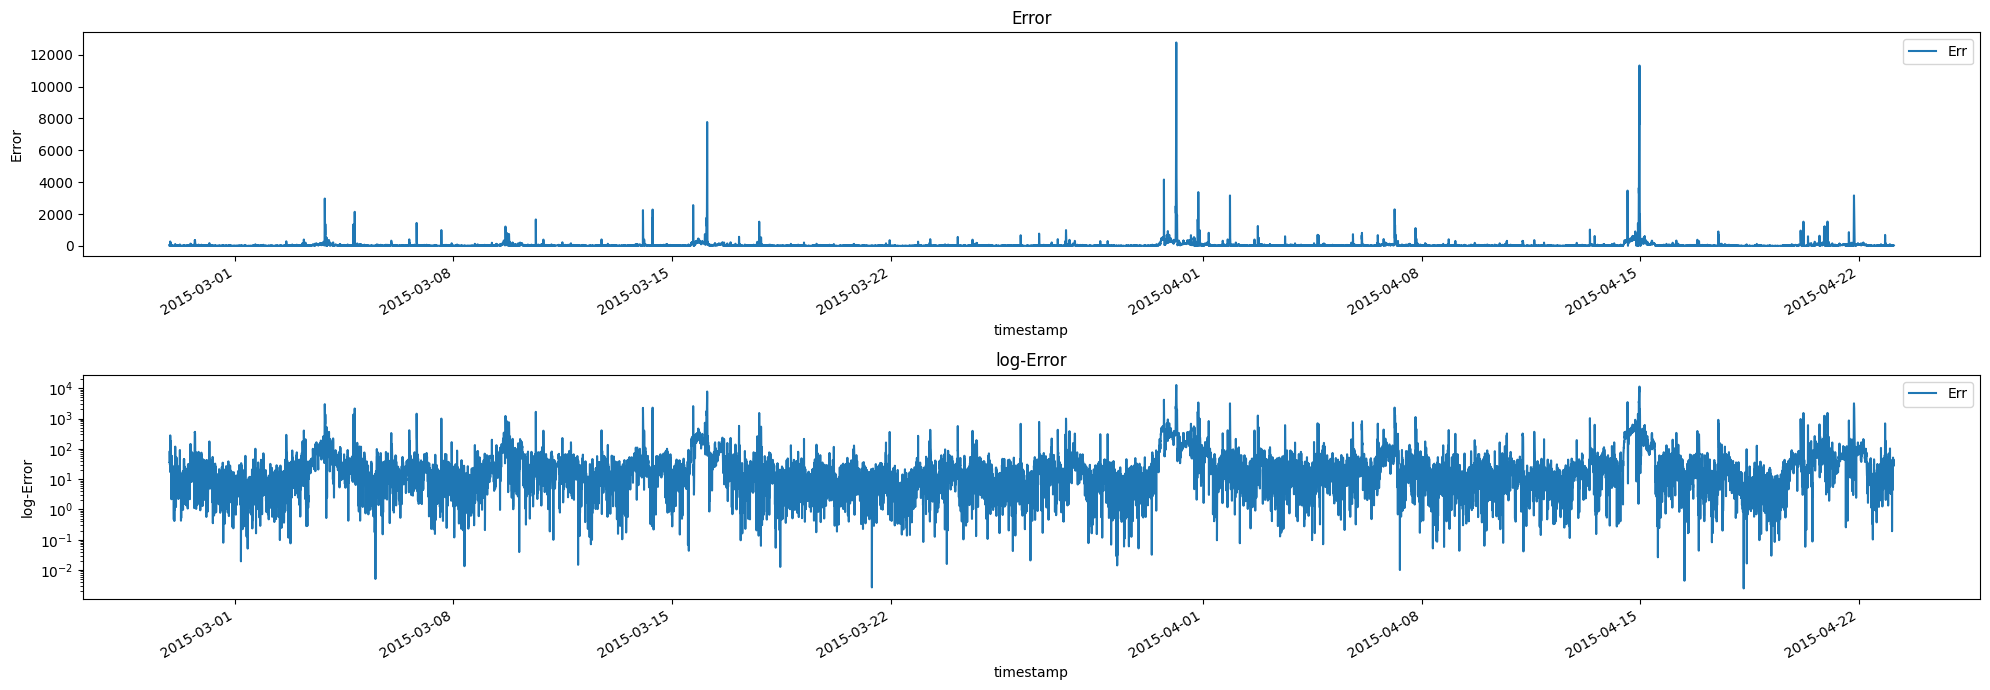

In [6]:
df['err'] = np.abs(df['expected_val'] - df['value'])

fig, ax = plt.subplots(2,1,figsize=(20,7))

df.err.plot(ax = ax[0], label ='Err')
ax[0].set_title('Error')
ax[0].set_ylabel('Error')

ax[1].set_yscale('log')
df.err.plot(ax = ax[1], label ='Err')
ax[1].set_title('log-Error')
ax[1].set_ylabel('log-Error')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

## Fitting errors to a pareto

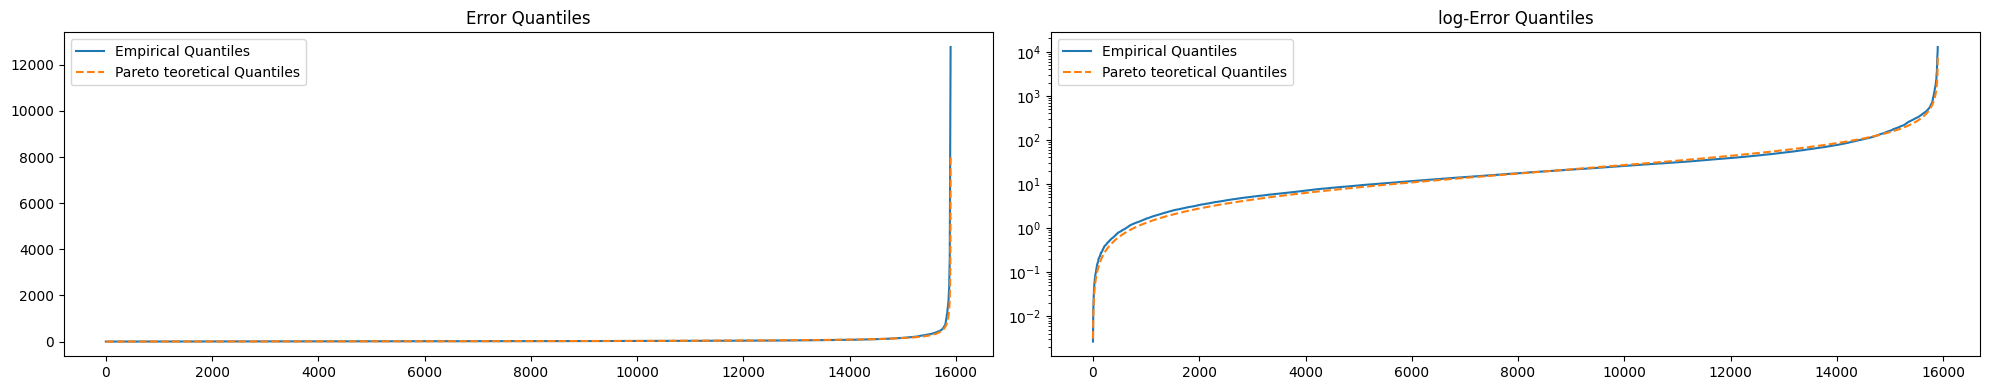

In [7]:
def get_quantiles(values, distribution):

    distribution = getattr(st, distribution)
    params = distribution.fit(values)

    values.sort()

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    x = []
    for i in range(1, len(values)):
        x.append((i-0.5) / len(values))

    y = list(distribution.ppf(x, loc=loc, scale=scale, *arg))
    emp_quantiles = values[1:]
    dist_quantiles = y

    return emp_quantiles, dist_quantiles, params

res = get_quantiles(df['err'].tolist(), 'pareto')

fig, ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(res[0], label = 'Empirical Quantiles')
ax[0].plot(res[1], label = 'Pareto teoretical Quantiles', linestyle = '--')
ax[0].set_title('Error Quantiles')

ax[1].set_yscale('log')
ax[1].plot(res[0], label = 'Empirical Quantiles')
ax[1].plot(res[1], label = 'Pareto teoretical Quantiles', linestyle = '--')
ax[1].set_title('log-Error Quantiles')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [8]:
is_pareto = []
params = []
args = st.pareto.fit(df['err'].dropna())

df_temp = df.copy()
#df_temp = df_temp[(df_temp.value != 0)]
#qnt = df_temp['value'].quantile(0.999)
#df_temp['value'] = np.where(df_temp['value'] > qnt, qnt, df_temp['value'])
#df_temp = df_temp[df_temp.value < qnt]

for i in tqdm(range(1000)):

    df_filtered = df_temp.sample(1000, replace = True)
    D, p_value = st.kstest(df_filtered['err'].tolist(), 'pareto', args = st.pareto.fit(df_filtered['err'].dropna()) )
    # Output the results

    if p_value > 0.01:
        is_pareto.append(1)
    else:
        is_pareto.append(0)
        
    params.append(st.pareto.fit(df_filtered['err'].dropna()))        

np.mean(is_pareto)

100%|██████████| 1000/1000 [00:03<00:00, 292.53it/s]


0.976

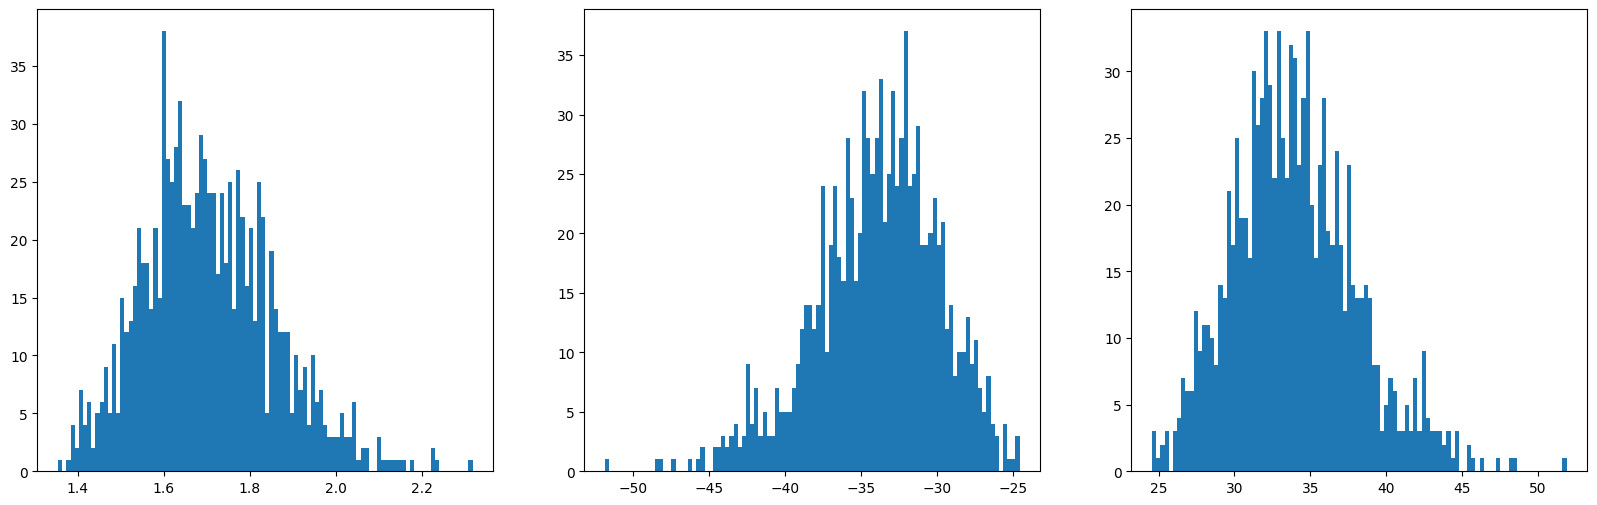

In [9]:
_, ax = plt.subplots(1,3, figsize = (20, 6))
ax[0].hist([x[0] for x in params], bins = 100)
ax[1].hist([x[1] for x in params], bins = 100)
ax[2].hist([x[2] for x in params], bins = 100)
plt.show()

In [10]:
np.median([x[0] for x in params]), np.median([x[1] for x in params]), np.median([x[2] for x in params])

(1.691255305719676, -33.67115023182305, 33.69482914463315)

In [11]:
st.pareto.fit(df['err'].dropna())

(1.6878783329520382, -33.578829610197715, 33.58130233886905)

## Detecting Anomalies

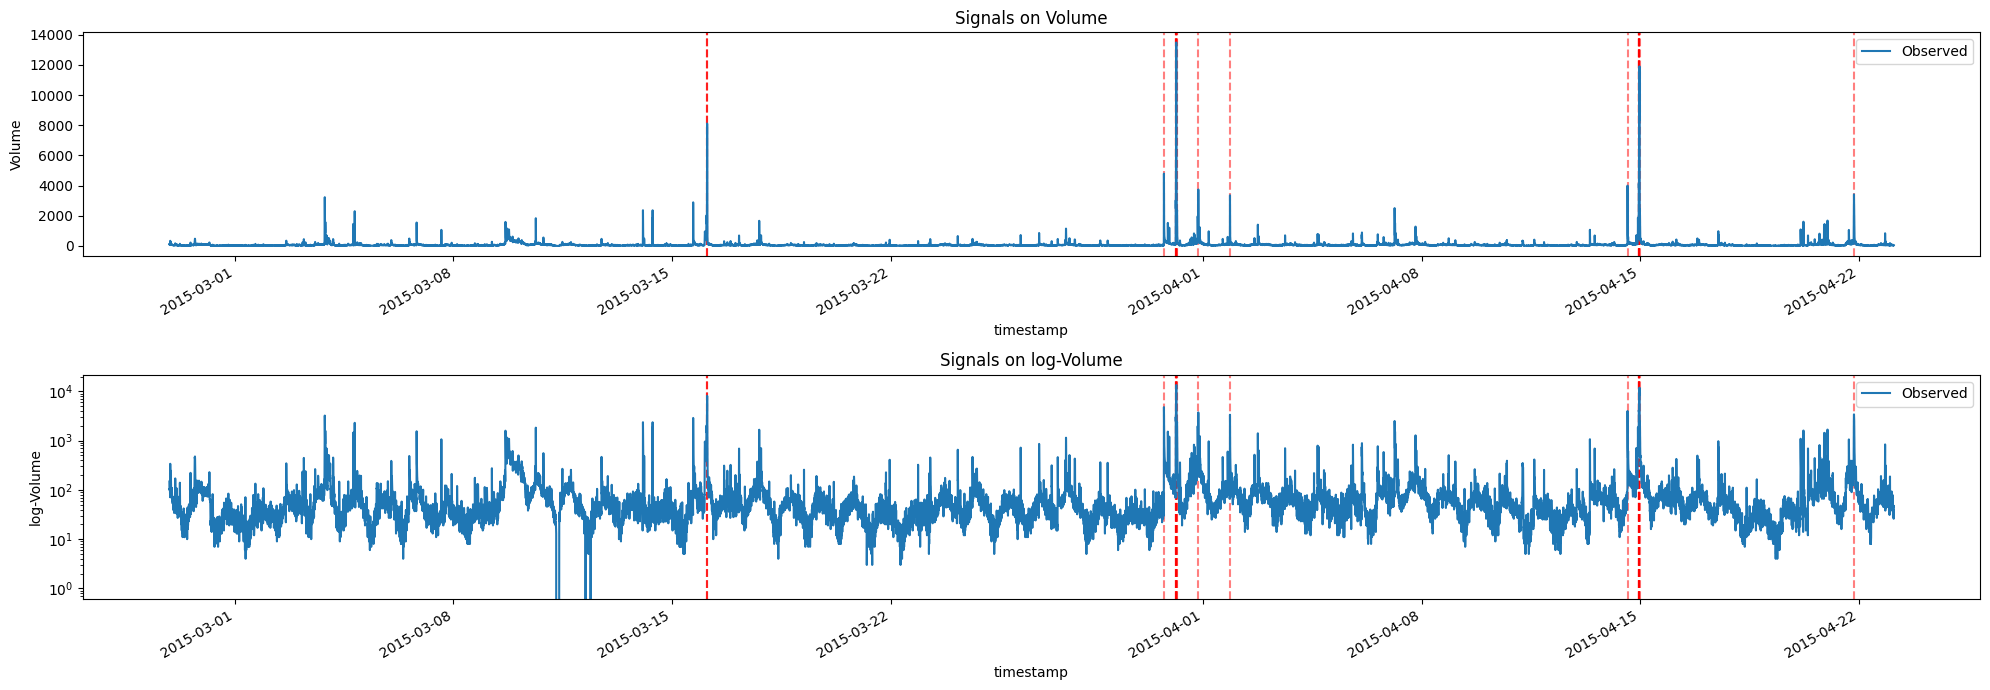

In [12]:
b, loc, scale = st.pareto.fit(df['err'].dropna())
df['signal'] = st.pareto.cdf(
    df['err'], 
    b=b, 
    loc=loc, 
    scale=scale
    ) > 0.9995

fig, ax = plt.subplots(2, 1, figsize=(20,7))

# plot signals
for x in pd.to_datetime(df[df.signal == 1].index): 
    ax[0].axvline(x=x, color = 'r', alpha = 0.5, linestyle ='--')
    ax[1].axvline(x=x, color = 'r', alpha = 0.5, linestyle ='--')

# plot observed values
df.value.plot(ax = ax[0], label='Observed')
ax[0].set_title('Signals on Volume')
ax[0].set_ylabel('Volume')

ax[1].set_yscale('log')
df.value.plot(ax = ax[1], label='Observed')
ax[1].set_title('Signals on log-Volume')
ax[1].set_ylabel('log-Volume')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

In [13]:
df[df.signal]

,timestamp,value,ma,pct_diff,expected_val,err,signal
timestamp,,,,,,,
2015-03-16 02:52:53,2015-03-16 02:52:53,6393,230.336806,27.755009,278.297088,6114.702912,True
2015-03-16 02:57:53,2015-03-16 02:57:53,8107,230.465278,35.176666,328.648768,7778.351232,True
2015-03-16 03:02:53,2015-03-16 03:02:53,5249,230.545139,22.767776,293.824538,4955.175462,True
2015-03-30 17:57:53,2015-03-30 17:57:53,4791,388.086806,12.345176,624.000774,4166.999226,True
2015-03-31 03:12:53,2015-03-31 03:12:53,6418,406.475694,15.789382,668.097582,5749.902418,True
2015-03-31 03:17:53,2015-03-31 03:17:53,7479,406.642361,18.392083,603.083324,6875.916676,True
2015-03-31 03:22:53,2015-03-31 03:22:53,10372,408.402778,25.396497,595.897629,9776.102371,True
2015-03-31 03:27:53,2015-03-31 03:27:53,13479,409.055556,32.951514,708.412031,12770.587969,True
2015-03-31 03:32:53,2015-03-31 03:32:53,8025,409.486111,19.597734,658.687517,7366.312483,True


# Real Time

In [14]:
   
def get_pareto_params(df, periods, threshold):
    df_temp = df.copy()
    df_temp['ma'] = df_temp['value'].rolling(window=periods, center=True, min_periods=1).mean()
    df_temp['pct_diff'] = df_temp['value'] / df_temp['ma']

    trend = np.array([df_temp['pct_diff'][i::periods].mean() for i in range(periods)])
    df_temp['expected_val'] = df_temp['ma'] * trend[np.arange(len(df_temp)) % periods]
    df_temp['err'] = np.abs(df_temp['value'] - df_temp['expected_val'])

    b, loc, scale = st.pareto.fit(df_temp[df_temp.value != 0]['err'].dropna())
    df_temp['signal'] = st.pareto.cdf(df_temp['err'], b=b, loc=loc, scale=scale) > threshold

    return df_temp

def analyze_signals(df, periods, threshold, skip_periods = 0):
    signals = set()
    
    for i in range(periods, len(df)):
        if i < periods*skip_periods: continue
        df_temp = df.iloc[:i+1].copy()
        df_temp = get_pareto_params(df_temp, periods, threshold)
        sub_df = df_temp.iloc[-periods:]
        
        new_signals = set(sub_df.loc[sub_df['signal'], 'timestamp']) - signals
        
        for sig in new_signals:
            print(f'New signal at datetime {df_temp.iloc[-1]["timestamp"]}, relative to timestamp {sig}')
        
        signals.update(new_signals)

    return signals

In [15]:
detected_signals = analyze_signals(df, periods=cycle_freq, threshold=0.9995, skip_periods=2)

New signal at datetime 2015-03-03 21:02:53, relative to timestamp 2015-03-03 21:02:53
New signal at datetime 2015-03-03 21:07:53, relative to timestamp 2015-03-03 21:07:53
New signal at datetime 2015-03-03 21:12:53, relative to timestamp 2015-03-03 21:12:53
New signal at datetime 2015-03-03 21:17:53, relative to timestamp 2015-03-03 21:17:53
New signal at datetime 2015-03-05 05:37:53, relative to timestamp 2015-03-04 20:07:53
New signal at datetime 2015-03-07 09:47:53, relative to timestamp 2015-03-06 19:42:53
New signal at datetime 2015-03-09 15:57:53, relative to timestamp 2015-03-09 15:57:53
New signal at datetime 2015-03-09 16:02:53, relative to timestamp 2015-03-09 16:02:53
New signal at datetime 2015-03-09 16:07:53, relative to timestamp 2015-03-09 16:07:53
New signal at datetime 2015-03-14 01:37:53, relative to timestamp 2015-03-14 01:37:53
New signal at datetime 2015-03-14 08:52:53, relative to timestamp 2015-03-14 08:52:53
New signal at datetime 2015-03-14 09:02:53, relative t

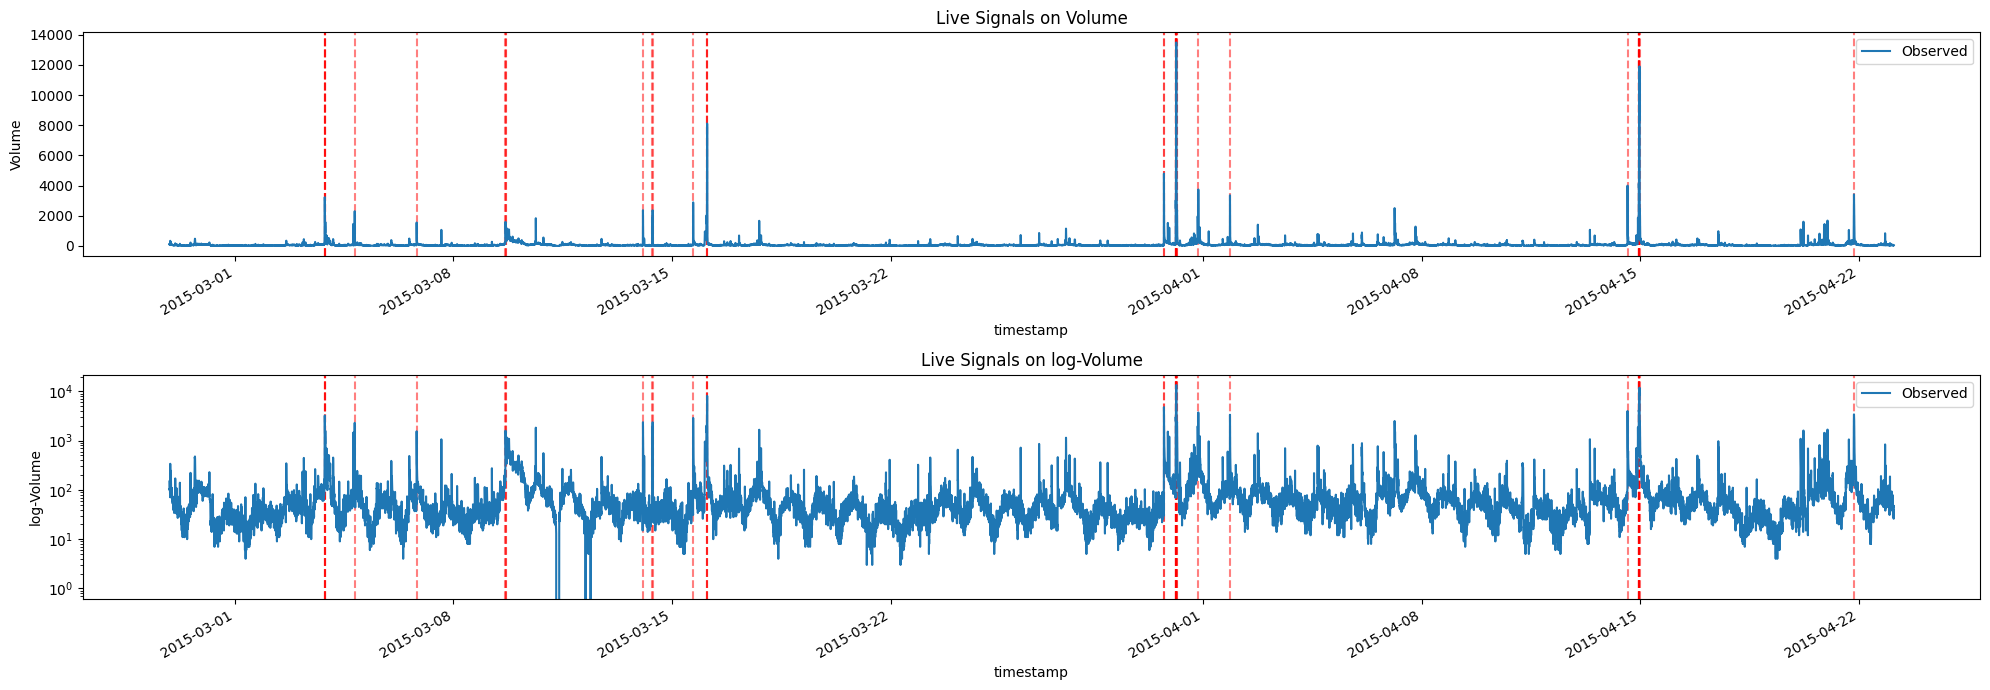

In [16]:
fig, ax = plt.subplots(2,1,figsize=(20,7))

for x in pd.to_datetime(list(detected_signals)): 
    ax[0].axvline(x=x, color = 'r', alpha = 0.5, linestyle ='--')
    ax[1].axvline(x=x, color = 'r', alpha = 0.5, linestyle ='--')

df.value.plot(ax = ax[0], label='Observed')
ax[0].set_title('Live Signals on Volume')
ax[0].set_ylabel('Volume')

ax[1].set_yscale('log')
df.value.plot(ax = ax[1], label='Observed')
ax[1].set_title('Live Signals on log-Volume')
ax[1].set_ylabel('log-Volume')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

### Checking common signals

In [ ]:
detected_signals = pd.to_datetime(list(detected_signals))
df['signal_live'] = [True if x in detected_signals else False for x in df.index]

In [18]:
df[(df.signal == 0) & (df.signal_live)]

,timestamp,value,ma,pct_diff,expected_val,err,signal,signal_live
timestamp,,,,,,,,
2015-03-03 21:02:53,2015-03-03 21:02:53,1698,147.503472,11.511593,240.194380,1457.805620,False,True
2015-03-03 21:07:53,2015-03-03 21:07:53,3228,147.496528,21.885261,253.833794,2974.166206,False,True
2015-03-03 21:12:53,2015-03-03 21:12:53,2234,147.489583,15.146832,240.857991,1993.142009,False,True
2015-03-03 21:17:53,2015-03-03 21:17:53,1452,147.506944,9.843604,211.634664,1240.365336,False,True
2015-03-04 20:07:53,2015-03-04 20:07:53,2300,67.638889,34.004107,158.297830,2141.702170,False,True
2015-03-06 19:42:53,2015-03-06 19:42:53,1549,67.114583,23.079932,106.850215,1442.149785,False,True
2015-03-09 15:57:53,2015-03-09 15:57:53,1592,256.854167,6.198070,376.590702,1215.409298,False,True
2015-03-09 16:02:53,2015-03-09 16:02:53,1464,257.315972,5.689503,370.591390,1093.408610,False,True
2015-03-09 16:07:53,2015-03-09 16:07:53,1422,257.732639,5.517345,311.302795,1110.697205,False,True


In [19]:
df[(df.signal) & (df.signal_live)]

,timestamp,value,ma,pct_diff,expected_val,err,signal,signal_live
timestamp,,,,,,,,
2015-03-16 02:52:53,2015-03-16 02:52:53,6393,230.336806,27.755009,278.297088,6114.702912,True,True
2015-03-16 02:57:53,2015-03-16 02:57:53,8107,230.465278,35.176666,328.648768,7778.351232,True,True
2015-03-16 03:02:53,2015-03-16 03:02:53,5249,230.545139,22.767776,293.824538,4955.175462,True,True
2015-03-30 17:57:53,2015-03-30 17:57:53,4791,388.086806,12.345176,624.000774,4166.999226,True,True
2015-03-31 03:12:53,2015-03-31 03:12:53,6418,406.475694,15.789382,668.097582,5749.902418,True,True
2015-03-31 03:17:53,2015-03-31 03:17:53,7479,406.642361,18.392083,603.083324,6875.916676,True,True
2015-03-31 03:22:53,2015-03-31 03:22:53,10372,408.402778,25.396497,595.897629,9776.102371,True,True
2015-03-31 03:27:53,2015-03-31 03:27:53,13479,409.055556,32.951514,708.412031,12770.587969,True,True
2015-03-31 03:32:53,2015-03-31 03:32:53,8025,409.486111,19.597734,658.687517,7366.312483,True,True


In [20]:
df[(df.signal) & (df.signal_live==0)]

,timestamp,value,ma,pct_diff,expected_val,err,signal,signal_live
timestamp,,,,,,,,
